### Name: Anushka Chaubey
### Roll: ZDA24M012
### Project: Non-Parametric Representation Learning with Kernels

**IMPORTANT INSTRUCTIONS**

1. Please load iris data (.csv) and mnist data (.mat)
2. Add the path to variable path below
3. Un-comment the dataset you want to run Run the notebook


In [18]:
ChooseData='IRIS'
path="/kaggle/input/iris-dataset/iris.csv"

# ChooseData='MNIST'
# path="/kaggle/input/mnist-original/mnist-original.mat"

# Import

In [17]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.decomposition import KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import pandas as pd
import tqdm
import numpy as np

import plotly.express as px
from skimage import io
import random

from sklearn.preprocessing import LabelBinarizer

import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn

import warnings
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img,img_to_array
import cv2

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer

from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
import tqdm
import numpy as np
import pandas as pd

# IRIS

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
def iris(path):
    # Load Iris dataset
    df = pd.read_csv(path)
    
    # Check if target column is named 'species' or something else
    print(df.columns)  # Just to verify
    
    # Separate features and labels
    X = df.drop("species", axis=1).values
    y = df["species"].values
    
    # Normalize feature values (optional but common)
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=0,
        stratify=y
    )
    
    # One-hot encode the labels
    encoder = LabelBinarizer()
    y_train_categorical = encoder.fit_transform(y_train)
    y_test_categorical = encoder.transform(y_test)
    
    # If needed for neural nets: convert to float32
    X_train_flat = X_train.astype(np.float32)
    X_test_flat = X_test.astype(np.float32)
    
    return X_train, X_test, y_train, y_test, X_train_flat, X_test_flat, y_train_categorical, y_test_categorical


# MNIST

In [20]:
import tqdm
# Load the MNIST .mat file
def mnist(path):
    mat = loadmat(path)
    # Extract images and labels
    X = mat["data"].T  # Shape (70000, 784)
    y = mat["label"][0]  # Shape (70000,)
    # Normalize pixel values (optional if using neural networks)
    X = X / 255.0
    # Convert flat images into 28x28 arrays
    X_images = [img_to_array(x.reshape(28, 28)) for x in tqdm.tqdm(X)]
    # Create DataFrame for compatibility with your COIL-100 pipeline
    df = pd.DataFrame({
        "image": X_images,
        "label": y
    })
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        df["image"], df["label"],
        test_size=0.3,
        random_state=0,
        stratify=df["label"]
    )
    # Convert Series to lists
    X_train = list(X_train)
    X_test = list(X_test)
    
    # Flatten the 28x28 images into 1D vectors
    X_train_flat = np.array([img.flatten() for img in X_train])
    X_test_flat = np.array([img.flatten() for img in X_test])
    
    # One-hot encode the labels
    encoder = LabelBinarizer()
    y_train_categorical = encoder.fit_transform(y_train)
    y_test_categorical = encoder.transform(y_test)

    return X_train, X_test, y_train, y_test, X_train_flat, X_test_flat, y_train_categorical, y_test_categorical


# GetData

In [21]:
if ChooseData=='IRIS':
    X_train, X_test, y_train, y_test, X_train_flat, X_test_flat, y_train_categorical, y_test_categorical = iris(path)
elif ChooseData=='MNIST':
    X_train, X_test, y_train, y_test, X_train_flat, X_test_flat, y_train_categorical, y_test_categorical = mnist(path)
    

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')


# Class clusters

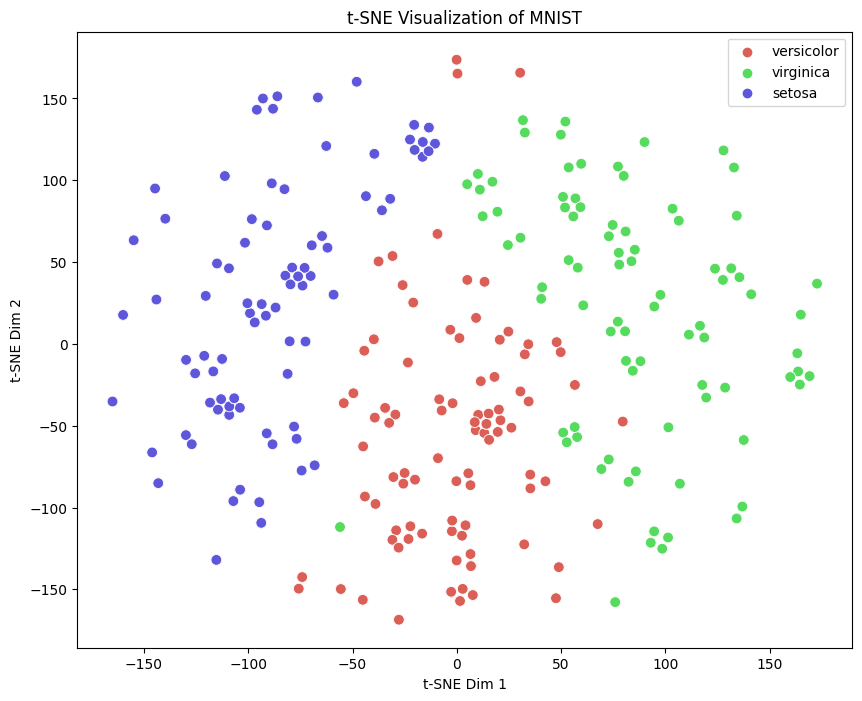

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Flatten the images to shape (n_samples, 784)
X_train_flat = np.array([img.flatten() for img in X_train])

# Sample a subset for faster t-SNE (optional but recommended for large datasets)
sample_size = 2000
indices = np.random.choice(len(X_train_flat), sample_size)
X_sample = X_train_flat[indices]
y_sample = np.array(y_train)[indices]

# Normalize the data before applying t-SNE
X_sample_scaled = StandardScaler().fit_transform(X_sample)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_sample_scaled)

# Plotting
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hls", len(np.unique(y_sample)))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_sample, palette=palette, legend="full", s=60)
plt.title("t-SNE Visualization of MNIST")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()


# Baseline Methods:
Vanilla KNN, PCA+KNN, Kernel PCA + KNN, Kernel AE + KNN

In [23]:
n=X_train.shape[1]-1

warnings.filterwarnings("ignore")
# ================================
# METHOD 1: KNN
# ================================


knn4 = KNeighborsClassifier(n_neighbors=3)
knn4.fit(X_train_flat, y_train_categorical)
y_pred = knn4.predict(X_test_flat)
weighted_f1 = f1_score(y_test_categorical, y_pred, average='weighted')

print("KNN Accuracy:", accuracy_score(y_test_categorical, y_pred))
print("Weighted F1 Score:", weighted_f1)
print('-'*60)
# # ================================
# # METHOD 2: PCA + KNN
# # ================================

pca = PCA(n_components=n)

X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train_pca, y_train_categorical)
y_pred_pca = knn3.predict(X_test_pca)
weighted_f1 = f1_score(y_test_categorical, y_pred_pca, average='weighted')

print("PCA + KNN Accuracy:", accuracy_score(y_test_categorical, y_pred_pca))
print("Weighted F1 Score:", weighted_f1)
print('-'*60)

# ================================
# METHOD 3: Kernel PCA + KNN
# ================================
kpca = KernelPCA(n_components=n, kernel='rbf', gamma=0.001)
X_train_kpca = kpca.fit_transform(X_train_flat)
X_test_kpca = kpca.transform(X_test_flat)

knn1 = KNeighborsClassifier(n_neighbors=3)
knn1.fit(X_train_kpca, y_train_categorical)
y_pred_kpca = knn1.predict(X_test_kpca)
weighted_f1 = f1_score(y_test_categorical, y_pred_kpca, average='weighted')

print("Kernel PCA + KNN Accuracy:", accuracy_score(y_test_categorical, y_pred_kpca))
print("Weighted F1 Score:", weighted_f1)
print('-'*60)


# ================================
# METHOD 4: Kernel Autoencoder + KNN
# ================================
class KernelAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(KernelAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

input_dim = X_train_flat.shape[1]
latent_dim = n
model = KernelAutoencoder(input_dim, latent_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_flat, dtype=torch.float32)

# Train autoencoder
model.train()
for epoch in range(50):
    optimizer.zero_grad()
    recon, _ = model(X_train_tensor)
    loss = criterion(recon, X_train_tensor)
    loss.backward()
    optimizer.step()
    # if epoch % 10 == 0:
    #     print(f"Epoch {epoch} - Reconstruction Loss: {loss.item():.4f}")

# Feature extraction
model.eval()
with torch.no_grad():
    _, X_train_embed = model(X_train_tensor)
    _, X_test_embed = model(X_test_tensor)

X_train_embed = X_train_embed.numpy()
X_test_embed = X_test_embed.numpy()

# KNN classification
knn2 = KNeighborsClassifier(n_neighbors=3)
knn2.fit(X_train_embed, y_train_categorical)
y_pred_ae = knn2.predict(X_test_embed)
weighted_f1 = f1_score(y_test_categorical, y_pred_ae, average='weighted')

print("Kernel Autoencoder + KNN Accuracy:", accuracy_score(y_test_categorical, y_pred_ae))
print("Weighted F1 Score:", weighted_f1)
print('-'*60)

KNN Accuracy: 0.9666666666666667
Weighted F1 Score: 0.9665831244778613
------------------------------------------------------------
PCA + KNN Accuracy: 0.9666666666666667
Weighted F1 Score: 0.9665831244778613
------------------------------------------------------------
Kernel PCA + KNN Accuracy: 0.9666666666666667
Weighted F1 Score: 0.9665831244778613
------------------------------------------------------------
Kernel Autoencoder + KNN Accuracy: 0.8
Weighted F1 Score: 0.7979797979797979
------------------------------------------------------------


### MNIST score
KNN Accuracy: 0.9704761904761905<br>
Weighted F1 Score: 0.9730461830719398

PCA + KNN Accuracy: 0.9762380952380952<br>
Weighted F1 Score: 0.9781691926927207

Kernel PCA + KNN Accuracy: 0.9688095238095238 <br>
Weighted F1 Score: 0.9714881739729376

Kernel Autoencoder + KNN Accuracy: 0.8047619047619048 <br>
Weighted F1 Score: 0.827451294248844

### IRIS score
KNN Accuracy: 0.9666666666666667<br>
Weighted F1 Score: 0.9665831244778613

PCA + KNN Accuracy: 0.9666666666666667<br>
Weighted F1 Score: 0.9665831244778613

Kernel PCA + KNN Accuracy: 0.9666666666666667<br>
Weighted F1 Score: 0.9665831244778613

Kernel Autoencoder + KNN Accuracy: 0.8666666666666667<br>
Weighted F1 Score: 0.8653198653198653

# Spectral Contrastive Kernel Learning

In [24]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === Helper: Build positive/negative pairs ===
def create_pairs(X, y):
    print("Creating positive and negative pairs...")
    n = len(X)
    pos_idx = []
    neg_idx = []

    for i in tqdm(range(n), desc="Pairing samples"):
        pos = np.random.choice(np.where(y == y[i])[0])
        neg = np.random.choice(np.where(y != y[i])[0])
        pos_idx.append(pos)
        neg_idx.append(neg)

    pos_idx = np.array(pos_idx)
    neg_idx = np.array(neg_idx)

    X_anchor = X
    X_pos = X[pos_idx]
    X_neg = X[neg_idx]

    return np.vstack([X_anchor, X_pos, X_neg]), n


import numpy as np
import torch
from tqdm import tqdm
from scipy.sparse.linalg import cg

def approximate_inverse_gpu(K, maxiter=1000, tol=1e-5):
    n = K.shape[0]
    device = K.device
    K_inv = torch.zeros((n, n), dtype=K.dtype, device=device)

    for i in range(n):
        b = torch.zeros(n, dtype=K.dtype, device=device)
        b[i] = 1.0

        x = torch.zeros_like(b)
        r = b - torch.matmul(K, x)
        p = r.clone()
        rs_old = torch.dot(r, r)

        for _ in range(maxiter):
            Ap = torch.matmul(K, p)
            alpha = rs_old / (torch.dot(p, Ap) + 1e-8)
            x += alpha * p
            r -= alpha * Ap
            rs_new = torch.dot(r, r)
            if torch.sqrt(rs_new) < tol:
                break
            p = r + (rs_new / rs_old) * p
            rs_old = rs_new

        K_inv[:, i] = x

    return K_inv


def spectral_kernel_learning(K_inv,K, n, h, lambd, lr, epochs, device):
    print("Spectral kernel learning ....")
    K_inv = K_inv.to(device)
    Z = torch.randn(h, 3 * n, requires_grad=True, dtype=torch.float32, device=device, )
    optimizer = torch.optim.Adam([Z], lr=lr)
    losses_total = []
    losses_contrastive = []
    losses_reg = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        # Split embeddings into anchors, positives, negatives
        Z_anchor = Z[:, :n]        # (h, n)
        Z_pos = Z[:, n:2*n]        # (h, n)
        Z_neg = Z[:, 2*n:3*n]      # (h, n)
        Z_anchor_norm = F.normalize(Z_anchor, dim=0)  # normalize each embedding vector
        Z_pos_norm = F.normalize(Z_pos, dim=0)
        Z_neg_norm = F.normalize(Z_neg, dim=0)
        
        dot_pos = torch.sum(Z_anchor_norm * Z_pos_norm, dim=0)
        dot_neg = torch.sum(Z_anchor_norm * Z_neg_norm, dim=0)

        # Vectorized loss:
        loss_terms = -2 * dot_pos + dot_neg ** 2
        loss = torch.sum(loss_terms)
        Z_norm = F.normalize(Z, dim=0)
        ZK = torch.matmul(Z_norm, K_inv)  # (h, 3n)
        reg = lambd * torch.sum(ZK * Z_norm)  
        total_loss = (loss) + reg
        total_loss.backward()
        optimizer.step()
        losses_total.append(total_loss.item())
        losses_contrastive.append(loss.item())
        losses_reg.append(reg.item())
        
        if epoch % 10 == 0 or epoch == epochs-1:
            print(f"Epoch {epoch} | Contrastive: {loss.item():.4f} | Reg: {reg.item():.4f} | Total: {total_loss.item():.4f}")

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 4))
    plt.plot(losses_total, label='Total Loss')
    plt.plot(losses_contrastive, label='Contrastive Loss')
    plt.plot(losses_reg, label='Regularization Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f'Training Loss|epochs: {epochs}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    return Z.detach().cpu(),K_inv.cpu()

def embed_all_points_gpu(Z, X_all, X_embed, K_inv, gamma, device):
    # Step 1: Compute RBF kernel between X_embed and X_all
    # Shape: (N, 3n)
    X_embed_norm = (X_embed ** 2).sum(dim=1).view(-1, 1)
    X_all_norm = (X_all ** 2).sum(dim=1).view(1, -1)
    dist_sq = X_embed_norm + X_all_norm - 2 * X_embed @ X_all.T
    K_x = torch.exp(-gamma * dist_sq)  # shape (N, 3n)

    # Step 2: Apply kernel inverse: K_inv @ k_x.T → shape (3n, N)
    # Then: Z @ (K_inv @ k_x.T) → (h, N) → transpose → (N, h)
    Z_embedded = (Z @ (K_inv @ K_x.T)).T  # shape: (N, h)

    return Z_embedded.cpu().numpy()



Using device: cuda


Using device: cuda
Original train size: 120 test size: 30
Creating positive and negative pairs...


Pairing samples: 100%|██████████| 120/120 [00:00<00:00, 18876.26it/s]

X_all shape: (360, 4)
Computing RBF kernel matrix...


torch.Size([360, 360]) <class 'torch.Tensor'>
Training embedding....
Spectral kernel learning ....
Epoch 0 | Contrastive: 0.0220 | Reg: 241.6913 | Total: 241.7133
Epoch 10 | Contrastive: -35.0610 | Reg: 226.6786 | Total: 191.6177
Epoch 20 | Contrastive: -68.4007 | Reg: 211.1700 | Total: 142.7693
Epoch 30 | Contrastive: -98.8415 | Reg: 195.3272 | Total: 96.4857
Epoch 40 | Contrastive: -125.6270 | Reg: 179.3196 | Total: 53.6926
Epoch 50 | Contrastive: -148.3722 | Reg: 163.3552 | Total: 14.9830
Epoch 60 | Contrastive: -167.0376 | Reg: 147.6776 | Total: -19.3600
Epoch 70 | Contrastive: -181.8842 | Reg: 132.5487 | Total: -49.3355
Epoch 80 | Contrastive: -193.3908 | Reg: 118.2204 | Total: -75.1704
Epoch 90 | Contrastive: -202.1469 | Reg: 104.9064 | Total: -97.2405
Epoch 100 | Contrastive: -208.7461 | Reg: 92.7565 | Total: -115.9896
Epoch 110 | Contrastive: -213.7190 | Reg: 81.8506 | Total: -131.8683
Epoch 120 | Contrastive: -217.4966 | Reg: 72.1993 | Total: -145.2972
Epoch 130 | Contrastive:

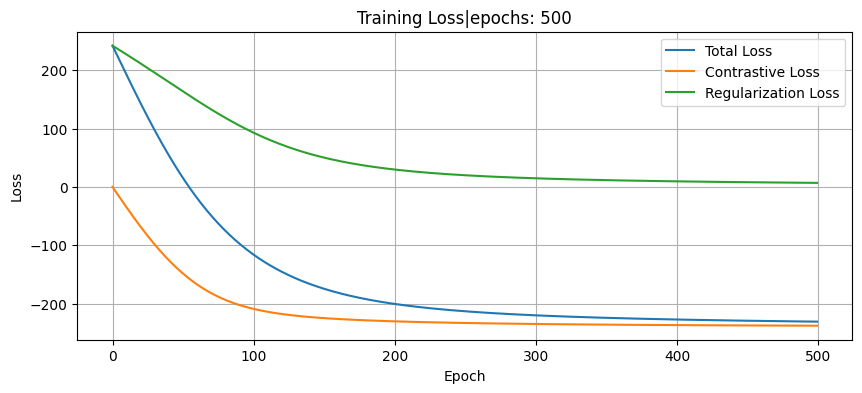

Embedding training data (vectorized)...
Embedding test data (vectorized)...
(120, 512) (120,) (30, 512) (30,)
(120, 4) (120,) (30, 4) (30,)


In [25]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
import random

# === Set device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === Parameters ===
gamma = 0.5  # RBF kernel parameter
h = 64*8        # Embedding dimension
lambd = 1e-5  # Regularization term
lr = 1e-2     # Learning rate
epochs = 500  # Training epochs
n_anchor = min(2000,len(X_train_flat))  # Anchor set size

# === STEP 1: Subsample anchor points from training set ===
print("Original train size:", len(X_train_flat), "test size:", len(X_test_flat))
subset_idx = np.random.choice(len(X_train_flat), size=n_anchor, replace=False)
X_anchor = np.array(X_train_flat)[subset_idx]
y_anchor = np.array(y_train)[subset_idx]

# === STEP 2: Build positive/negative pairs ===
X_all, n = create_pairs(X_anchor, y_anchor)
print("X_all shape:", X_all.shape)  # Should be (3 * n, 784)

# === STEP 3: Compute kernel matrix ===
print("Computing RBF kernel matrix...")
K = rbf_kernel(X_all, X_all, gamma=gamma).astype(np.float32)  # shape (3n, 3n)
K = torch.tensor(K, dtype=torch.float32, device=device)
lambda_reg = 1e-5  # or try 1e-4, 1e-3 if needed
K_reg = K + lambda_reg * torch.eye(K.size(0), device=K.device)
# K_inv = torch.linalg.inv(K)  # or 
K_inv=torch.inverse(K_reg)
# K_inv=approximate_inverse_gpu(K)
print(K_inv.shape,type(K_inv)) 
# K_inv = approximate_inverse_gpu(K)

# === STEP 4: Train the embeddings ===
print("Training embedding....")
Z,K_inv = spectral_kernel_learning(K_inv,K, n=n, h=h, lambd=1e-5, lr=lr, epochs=500, device=device)
# === STEP 5: Extract anchor embeddings ===
Z_train = Z[:, :n].T.cpu().numpy()
y_train_sub = y_anchor 

# Convert all inputs to torch tensors
X_all_tensor = torch.tensor(X_all, dtype=torch.float32, device=device)
X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_flat, dtype=torch.float32, device=device)
Z = Z.to(device)
K_inv = K_inv.to(device)

# Embed full training set
print("Embedding training data (vectorized)...")
Z_train_full = embed_all_points_gpu(Z, X_all_tensor, X_train_tensor, K_inv, gamma, device)

# Embed test set
print("Embedding test data (vectorized)...")
Z_test_full = embed_all_points_gpu(Z, X_all_tensor, X_test_tensor, K_inv, gamma, device)

print(Z_train_full.shape,y_train.shape,Z_test_full.shape,y_test.shape)
print(X_train_flat.shape,y_train.shape,X_test_flat.shape,y_test.shape)

In [26]:
from sklearn.metrics import f1_score

# === STEP 7: Spectral KNN ===
print("Spectral Constrative Kernel Learning + KNN ...")
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(Z_train_full, y_train)
y_pred = knn.predict(Z_test_full)
accuracy = knn.score(Z_test_full, y_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"KNN Accuracy: {accuracy * 100:.2f}%")
print('-'*60)
# === STEP 8: Classification using KNN ===
print("Vanilla KNN ...")
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_flat, y_train)
accuracy = knn.score(X_test_flat, y_test)
print(f"KNN Accuracy: {accuracy * 100:.2f}%")



Spectral Constrative Kernel Learning + KNN ...
KNN Accuracy: 96.67%
------------------------------------------------------------
Vanilla KNN ...
KNN Accuracy: 96.67%


# Simple Constrastive Kernel Learning

In [27]:
import torch
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
def create_triplets(X, y, num_triplets):
    anchors, positives, negatives = [], [], []
    classes = np.unique(y)
    class_to_indices = {c: np.where(y == c)[0] for c in classes}
    
    for _ in range(num_triplets):
        anchor_class = np.random.choice(classes)
        neg_class = np.random.choice(classes[classes != anchor_class])
        
        anchor_idx = np.random.choice(class_to_indices[anchor_class])
        pos_idx = np.random.choice(class_to_indices[anchor_class])
        while pos_idx == anchor_idx:
            pos_idx = np.random.choice(class_to_indices[anchor_class])
        
        neg_idx = np.random.choice(class_to_indices[neg_class])
        
        anchors.append(X[anchor_idx])
        positives.append(X[pos_idx])
        negatives.append(X[neg_idx])
        
    return np.array(anchors), np.array(positives), np.array(negatives)

# CKL embedding function with PyTorch GPU tensors
def ckl_embedding_torch(X_anchor, X_pos, X_neg, gamma=0.01, embedding_dim=64):
    """
    GPU-accelerated and stable implementation of CKL embedding in PyTorch.
    Assumes inputs are NumPy arrays.
    """
    import torch
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Normalize inputs to [0, 1]
    X_anchor = X_anchor.astype(np.float32) / 255.0
    X_pos = X_pos.astype(np.float32) / 255.0
    X_neg = X_neg.astype(np.float32) / 255.0

    # Convert to torch tensors on GPU
    X_anchor_t = torch.tensor(X_anchor, dtype=torch.float32, device=device)
    X_pos_t = torch.tensor(X_pos, dtype=torch.float32, device=device)
    X_neg_t = torch.tensor(X_neg, dtype=torch.float32, device=device)

    # Define RBF kernel
    def rbf_kernel_torch(X1, X2, gamma):
        X1 = X1.view(X1.shape[0], -1)
        X2 = X2.view(X2.shape[0], -1)
        X1_sq = (X1 ** 2).sum(dim=1).unsqueeze(1)
        X2_sq = (X2 ** 2).sum(dim=1).unsqueeze(0)
        dist_sq = X1_sq + X2_sq - 2 * torch.matmul(X1, X2.T)
        return torch.exp(-gamma * dist_sq)

    # Compute kernel matrices
    K = rbf_kernel_torch(X_anchor_t, X_anchor_t, gamma)
    K_pos = rbf_kernel_torch(X_anchor_t, X_pos_t, gamma)
    K_neg = rbf_kernel_torch(X_anchor_t, X_neg_t, gamma)
    K_pp = rbf_kernel_torch(X_pos_t, X_pos_t, gamma)
    K_nn = rbf_kernel_torch(X_neg_t, X_neg_t, gamma)
    K_np = rbf_kernel_torch(X_neg_t, X_pos_t, gamma)

    # Construct matrices
    K3 = K_nn - K_pos
    K_delta = K_nn + K_pp - K_np - K_np.T

    K1_top = torch.cat((K, K3), dim=1)
    K1_bottom = torch.cat((K3, K_delta), dim=1)
    K1 = torch.cat((K1_top, K1_bottom), dim=0)

    left = torch.cat((K3, K_delta), dim=0)
    K_inv = torch.linalg.pinv(K + 1e-2 * torch.eye(K.shape[0], device=device))  # safer inverse
    right = torch.cat((K, K_inv - K_pos), dim=1)
    B = left @ right
    K2 = -2 * (B + B.T)

    # Regularize K1
    K1 += 1e-1 * torch.eye(K1.shape[0], device=device)  # stronger reg
    eigvals, eigvecs = torch.linalg.eigh(K1)

    eigvals = torch.clamp(eigvals, min=1e-1)  # avoid division explosion
    D_inv_sqrt = torch.diag(1.0 / torch.sqrt(eigvals))
    K1_inv_sqrt = eigvecs @ D_inv_sqrt @ eigvecs.T

    M = K1_inv_sqrt @ K2 @ K1_inv_sqrt

    # Final regularization for M to avoid eig-failure
    M += 1e-2 * torch.eye(M.shape[0], device=device)

    # Decompose M
    eigvals_M, eigvecs_M = torch.linalg.eigh(M)

    # Sort and select top eigenvectors with non-negative eigenvalues
    sorted_indices = torch.argsort(eigvals_M, descending=True)
    valid_indices = [i.item() for i in sorted_indices if eigvals_M[i] >= 0][:embedding_dim]

    if len(valid_indices) < embedding_dim:
        raise ValueError(f"Only {len(valid_indices)} valid directions found. Reduce `embedding_dim`.")

    A2 = eigvecs_M[:, valid_indices]
    A = K1_inv_sqrt @ A2  # Projection matrix

    return A, X_anchor_t, X_pos_t, X_neg_t


# Embedding new points with torch on GPU
def embed_new_points_torch_batched(X_star, A, X_anchor_t, X_pos_t, X_neg_t, gamma=0.1, batch_size=512):
    A = A.to(device)
    X_anchor_t = X_anchor_t.to(device)
    X_pos_t = X_pos_t.to(device)
    X_neg_t = X_neg_t.to(device)

    X_star_t = torch.tensor(X_star, dtype=torch.float32, device=device)
    n = X_star_t.shape[0]
    z_list = []

    def rbf_kernel_torch(X1, X2, gamma):
        X1 = X1.view(X1.shape[0], -1)  # shape [100, 28*28*1 = 784]
        X2 = X2.view(X2.shape[0], -1)
        # Computes pairwise RBF kernel between X1 and X2
        X1_norm = (X1 ** 2).sum(dim=1).unsqueeze(1)  # (b, 1)
        X2_norm = (X2 ** 2).sum(dim=1).unsqueeze(0)  # (1, n)
        dist_sq = X1_norm + X2_norm - 2 * X1 @ X2.T
        return torch.exp(-gamma * dist_sq)

    for i in range(0, n, batch_size):
        X_batch = X_star_t[i:i+batch_size]
        k_anchor = rbf_kernel_torch(X_batch, X_anchor_t, gamma)
        k_neg = rbf_kernel_torch(X_batch, X_neg_t, gamma)
        k_pos = rbf_kernel_torch(X_batch, X_pos_t, gamma)
        
        combined = torch.cat((k_anchor, k_neg - k_pos), dim=1)
        z_batch = combined @ A
        z_list.append(z_batch.detach().cpu())

    return torch.cat(z_list, dim=0).numpy()




Using device: cuda


In [29]:
# --- Main code ---

num_triplets = 2000
X_anchor, X_pos, X_neg = create_triplets(X_train, y_train, num_triplets)

A, X_anchor_t, X_pos_t, X_neg_t = ckl_embedding_torch(X_anchor, X_pos, X_neg, gamma=0.5, embedding_dim=64*8)
Z_train = embed_new_points_torch_batched(X_train, A, X_anchor_t, X_pos_t, X_neg_t, gamma=0.5)
Z_test = embed_new_points_torch_batched(X_test, A, X_anchor_t, X_pos_t, X_neg_t, gamma=0.5)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(Z_train, y_train)

accuracy = knn.score(Z_test, y_test)
print(f"CKL + KNN accuracy (GPU optimized): {accuracy*100:.2f}%")


CKL + KNN accuracy (GPU optimized): 90.00%


# Results

### MNIST score
KNN Accuracy: 0.9704761904761905<br>
Weighted F1 Score: 0.9730461830719398

PCA + KNN Accuracy: 0.9762380952380952<br>
Weighted F1 Score: 0.9781691926927207

Kernel PCA + KNN Accuracy: 0.9688095238095238 <br>
Weighted F1 Score: 0.9714881739729376

Kernel Autoencoder + KNN Accuracy: 0.8047619047619048 <br>
Weighted F1 Score: 0.827451294248844

Spectral Kernel Learning + KNN Accuracy: 0.93

CKL + KNN accuracy: 90.52%

### IRIS score
KNN Accuracy: 0.9666666666666667<br>
Weighted F1 Score: 0.9665831244778613

PCA + KNN Accuracy: 0.9666666666666667<br>
Weighted F1 Score: 0.9665831244778613

Kernel PCA + KNN Accuracy: 0.9666666666666667<br>
Weighted F1 Score: 0.9665831244778613

Kernel Autoencoder + KNN Accuracy: 0.8666666666666667<br>
Weighted F1 Score: 0.8653198653198653

Spectral Kernel Learning + KNN Accuracy: 0.966

Contrastive Kernel Learning + KNN Accuracy: 0.93